## Leaderboard benchmark 4: detrended Siegel model
Winning model from first round of bootstrap benchmarking against naive control.
1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)
3. [Regress & predict](#regress_predict)
5. [Results](#results)
6. [TODO](#TODO)

In [8]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
import functions.plotting_functions as plot_funcs
import functions.data_manipulation_functions as data_funcs

import pandas as pd
import matplotlib

print(f'Python: {sys.version}')
print()
print(f'Pandas {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}') # type: ignore

# Replace matplotlib with pyplot interface
del matplotlib
import matplotlib.pyplot as plt

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Pandas 1.4.3
Matplotlib: 3.6.3


<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model

In [9]:
# Define model orders to construct submission files for
model_orders = [4,6,8]

# Experiment date
experiment_date_string = '2023-02-13'

<a name="load_inspect"></a>
### 2. Load & inspect

In [10]:
# Read zipped csv into pandas dataframe
training_df = pd.read_csv(f'{conf.KAGGLE_DATA_PATH}/train.csv.zip', compression='zip')

# Set dtype on first day of month column
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

# Print out some metadata and sample rows
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [11]:
# Makes sure the rows are in chronological order within each county
training_df = training_df.sort_values(by=['cfips', 'first_day_of_month'])

# Calculate and add column for month to month change in MBD
training_df['microbusiness_density_change'] = training_df.groupby(['cfips'])['microbusiness_density'].diff() # type: ignore

# Get rid of first NA row for each county
training_df.dropna(inplace=True)

training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_change
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,-0.122812
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,0.170973
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,-0.062610
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,0.000000
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,-0.024143


<a name="regress_predict"></a>
### 3. Regress and predict

In [12]:
# Prepare test dataframe to add our predictions into for submission

# Read zipped csv into pandas dataframe
test_df = pd.read_csv(f'{conf.KAGGLE_DATA_PATH}/test.csv')

# Set dtype on first day of month column
test_df['first_day_of_month'] =  pd.to_datetime(test_df['first_day_of_month'])

# Sort by cfips and timepoint to match predictions
test_df.sort_values(['cfips', 'first_day_of_month'], inplace=True)

# Clean up
test_df.reset_index(inplace=True, drop=True)

# Print out some metadata and sample rows
test_df.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


In [13]:
# Get list of unique cfips
cfips_list = training_df['cfips'].drop_duplicates(keep='first').to_list()


    Sample input data:

                row_id  timepoint_num  cfips          county    state  \
0  1001_2022-07-01              0   1001  Autauga County  Alabama   
1  1001_2022-08-01              1   1001  Autauga County  Alabama   
2  1001_2022-09-01              2   1001  Autauga County  Alabama   
3  1001_2022-10-01              3   1001  Autauga County  Alabama   

  first_day_of_month  microbusiness_density  active  \
0         2022-07-01               3.437971    1461   
1         2022-08-01               3.423852    1455   
2         2022-09-01               3.442677    1463   
3         2022-10-01               3.463856    1472   

   microbusiness_density_change  
0                      0.091773  
1                     -0.014119  
2                      0.018825  
3                      0.021178  

    Forecast range: [4, 5, 6, 7, 8, 9, 10, 11]
    


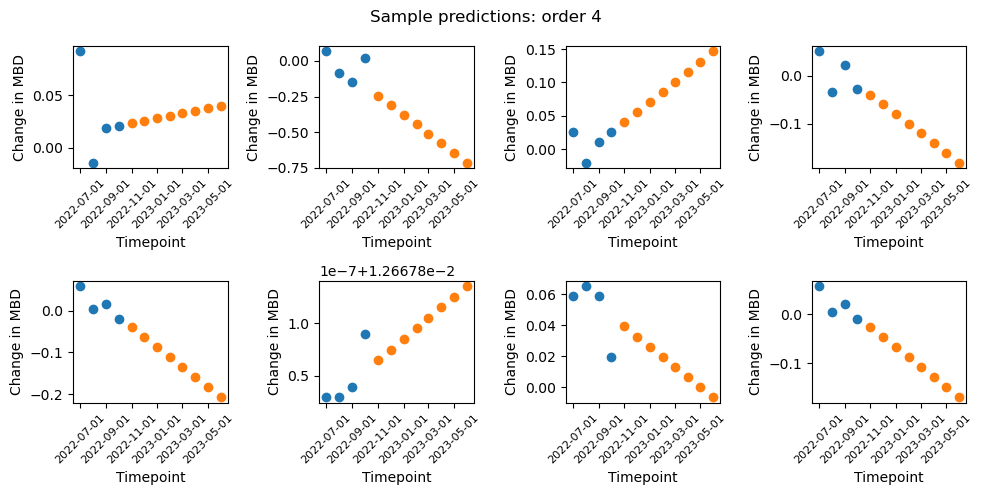

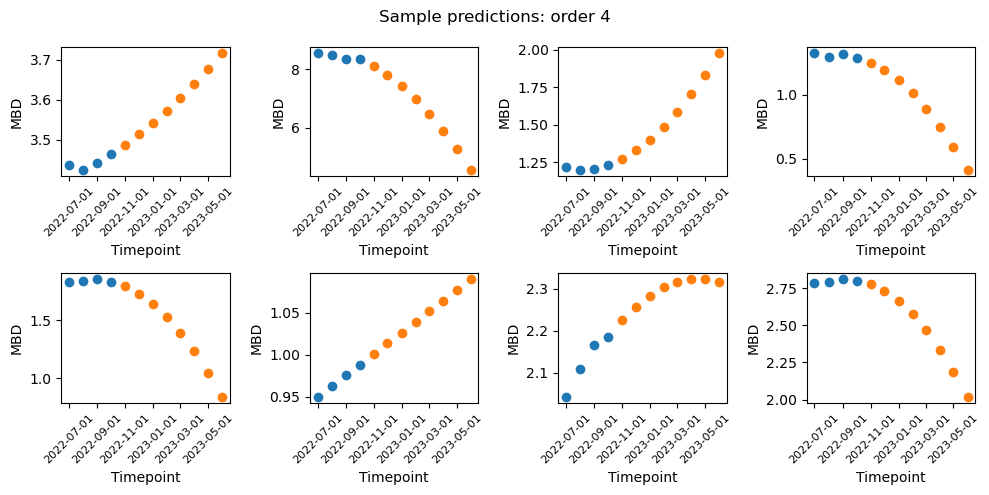


    Sample input data:

                row_id  timepoint_num  cfips          county    state  \
0  1001_2022-05-01              0   1001  Autauga County  Alabama   
1  1001_2022-06-01              1   1001  Autauga County  Alabama   
2  1001_2022-07-01              2   1001  Autauga County  Alabama   
3  1001_2022-08-01              3   1001  Autauga County  Alabama   
4  1001_2022-09-01              4   1001  Autauga County  Alabama   
5  1001_2022-10-01              5   1001  Autauga County  Alabama   

  first_day_of_month  microbusiness_density  active  \
0         2022-05-01               3.313253    1408   
1         2022-06-01               3.346197    1422   
2         2022-07-01               3.437971    1461   
3         2022-08-01               3.423852    1455   
4         2022-09-01               3.442677    1463   
5         2022-10-01               3.463856    1472   

   microbusiness_density_change  
0                     -0.058829  
1                      0.032944  

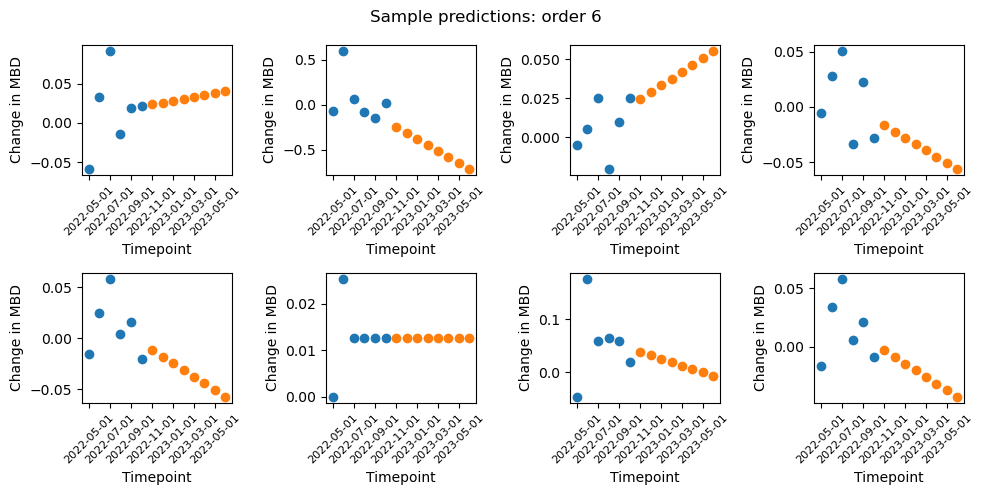

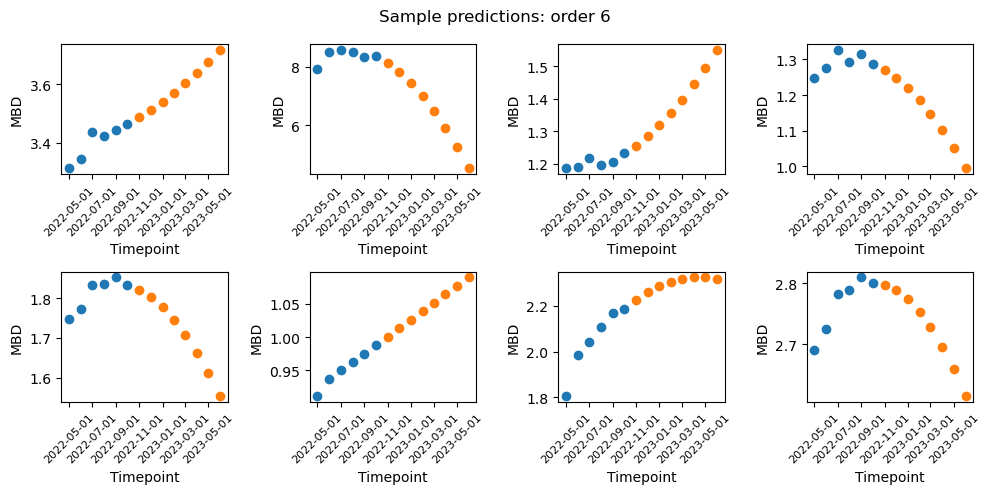


    Sample input data:

                row_id  timepoint_num  cfips          county    state  \
0  1001_2022-03-01              0   1001  Autauga County  Alabama   
1  1001_2022-04-01              1   1001  Autauga County  Alabama   
2  1001_2022-05-01              2   1001  Autauga County  Alabama   
3  1001_2022-06-01              3   1001  Autauga County  Alabama   
4  1001_2022-07-01              4   1001  Autauga County  Alabama   
5  1001_2022-08-01              5   1001  Autauga County  Alabama   
6  1001_2022-09-01              6   1001  Autauga County  Alabama   
7  1001_2022-10-01              7   1001  Autauga County  Alabama   

  first_day_of_month  microbusiness_density  active  \
0         2022-03-01               3.336785    1418   
1         2022-04-01               3.372082    1433   
2         2022-05-01               3.313253    1408   
3         2022-06-01               3.346197    1422   
4         2022-07-01               3.437971    1461   
5         2022-08-0

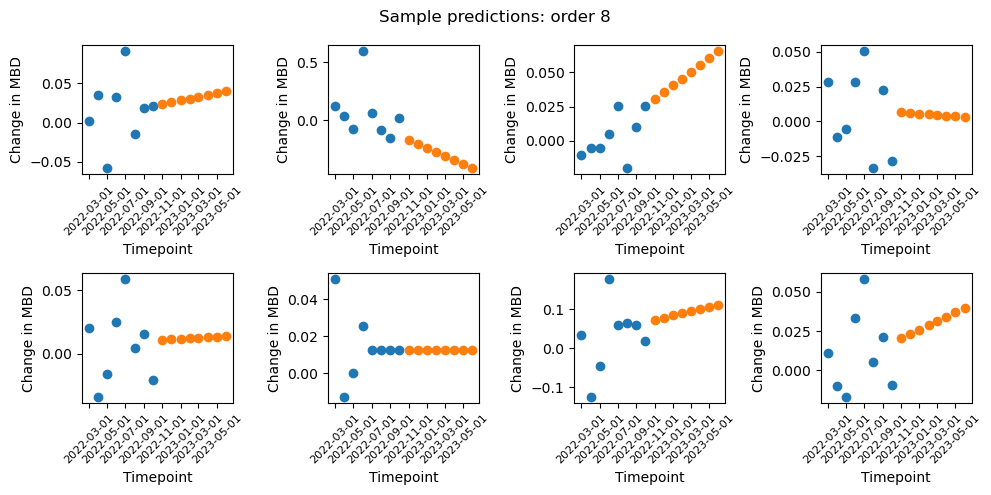

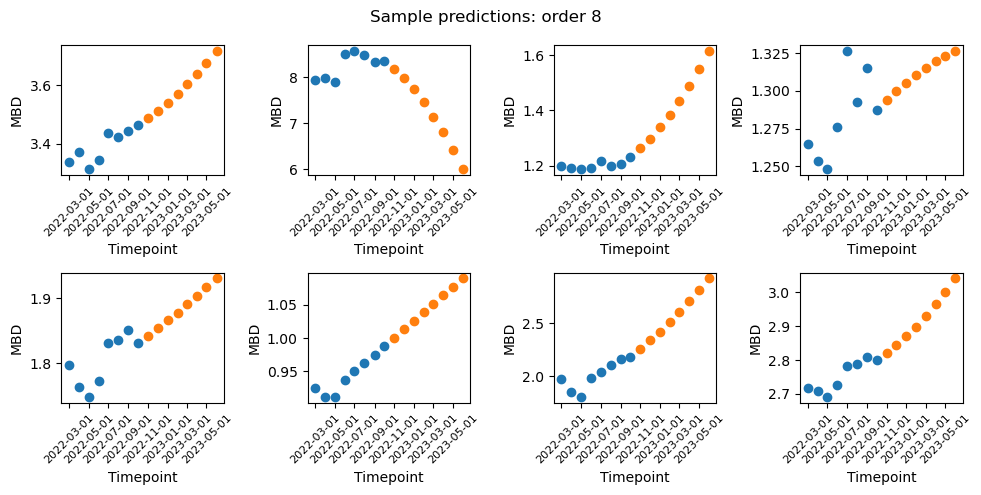

In [14]:
for model_order in model_orders:
    # Get model_order most recent data points for each county
    recent_values_df = data_funcs.build_OLS_data(training_df, model_order)

    # Make list of ints for prediction x based on model order
    xforecast = list(range(model_order, (model_order + 8)))

    # Show sample data for sanity check
    print_values = {
        'sample_input_data': recent_values_df.head(model_order),
        'forecast_range': xforecast
    }

    string = '''
    Sample input data:

    {sample_input_data}

    Forecast range: {forecast_range}
    '''
    print(string.format(**print_values))

    # Holder dict for results
    predictions = {
        'cfips': [],
        'microbusiness_density_change': [],
        'microbusiness_density': []
    }

    # Loop on cfips list and make Seigel predictions for each
    for cfips in cfips_list:

        recent_values = recent_values_df[recent_values_df['cfips'] == cfips]

        change_predictions = data_funcs.siegel_prediction(
            recent_values,
            xinput = 'timepoint_num',
            yinput = 'microbusiness_density_change',
            xforecast = xforecast
        )

        # Store change predictions
        predictions['cfips'].extend([cfips] * 8)
        predictions['microbusiness_density_change'].extend(change_predictions)

        # Calculate absolute MBD from change predictions
        MBD_predictions = []
        last_MBD = recent_values['microbusiness_density'].iloc[-1]

        for change_prediction in change_predictions:
            MBD = last_MBD + change_prediction
            MBD_predictions.append(MBD)
            last_MBD = MBD

        # Add MBD predictions to results
        predictions['microbusiness_density'].extend(MBD_predictions)

    # Convert predictions dict to dataframe
    prediction_df = pd.DataFrame(predictions)

    # Concatenate test and prediction dataframes
    submission_df = pd.concat([test_df, prediction_df.drop(['cfips'], axis=1)], axis=1)

    # Plot a few examples of change in MBD
    plt = plot_funcs.n_by_n_prediction_scatterplot(
        input_data = recent_values_df,
        predictions = submission_df,
        x_variable = 'first_day_of_month',
        xlabel = 'Timepoint',
        y_variable = 'microbusiness_density_change',
        ylabel = 'Change in MBD',
        cfips_list = cfips_list,
        rows = 2,
        columns = 4,
        fig_height = 5,
        main_title = f'Sample predictions: order {model_order}'
    )


    # Plot a few examples of MBD
    plt = plot_funcs.n_by_n_prediction_scatterplot(
        input_data = recent_values_df,
        predictions = submission_df,
        x_variable = 'first_day_of_month',
        xlabel = 'Timepoint',
        y_variable = 'microbusiness_density',
        ylabel = 'MBD',
        cfips_list = cfips_list,
        rows = 2,
        columns = 4,
        fig_height = 5,
        main_title = f'Sample predictions: order {model_order}'
    )


    plt.show()

    # Drop un-needed rows from our prediction so the format matches the sample submission
    submission_df.drop(['cfips', 'first_day_of_month', 'microbusiness_density_change'], axis=1, inplace=True)

    # Write csv
    output_file = f'{conf.BENCHMARKING_PATH}/{experiment_date_string}_detrended_siegel_model_order{model_order}_submission.csv'
    submission_df.to_csv(output_file, sep=',', index=False)

In [15]:
submission_df.head()

,row_id,microbusiness_density
0,1001_2022-11-01,3.487387
1,1001_2022-12-01,3.513272
2,1001_2023-01-01,3.541510
3,1001_2023-02-01,3.572101
4,1001_2023-03-01,3.605046


<a name="results"></a>
### 4. Results

**Raw data OLS**
Gosh, this performs much worse that the totally naive model which just predicts no change! I mean, I didn't think this would be a winning solution, but I would have bet that regressing a few points back from the forecast origin would have helped somewhat. I wonder if part of the issue is that it's not November being scored on the public leaderboard. This could explain the loss in accuracy. If January is being scored, it would make sense that our OLS fit, which only saw data up to October would be way off by the time a few months had passed. I can test this pretty easily by submitting a few dummy predictions with the naive model's values for one month at a time and zeros or NANs for the others. Unfortunately, that experiment will have to wait, I am out of submissions for today. Note to self - be more careful with file uploads in the future!

**Detrended OLS**
No improvement. In fact our best detrended result is only slightly better than our worst result on the raw data. I'm a bit surprised by this because most of the sample plots look ok-ish. Especially considering that we are only being scored on the first prediction. Maybe there are a few counties in there where this approach is really bad and those contribute significantly to the error? not sure. Also, 1) we know OLS is not really the right tool for this job and 2) I worry that all this detrending stuff is mostly helpful for longer range predictions. For right now, we are only predicting the next datapoint in the timeseries. So, I think there would have to be a pretty strong trend for it to overpower whatever noise is going on from timepoint to timepoint. I can immediately think of two things we could do to attempt and improve this result. First, try a larger model order - if you look at the raw data OLS results, the best score was achieved with a model order of 3. Increasing or decreasing the model order beyond that hurts the performance. But for our detrended model, the performance is still continuing to improve as the model order increases. The second thing we could do it pick the model order to use for prediction county by county based on the fit statistics.

**Detrended Siegel**
Better, compared to the OLS models, but still not as good as the naive control. Interesting part is - according the the benchmarking Siegel should win by a pretty good margin. We can probably chalk it up to the specific test set on the public leaderboard. There is a bit of spread in the bootstrapped SMAPE score distribution, enough to include the SMAPE values we are seeing on the public leaderboard.

Anyway, oneshot naive is still the winner, but now by a smaller margin. 

Here are the results so far:
* Detrended Siegel model order 10: SMAPE = 1.4016
* Detrended Siegel model order 12: SMAPE = 1.351
* Detrended Siegel model order 14: SMAPE = 1.3027
* Detrended Siegel model order 16: SMAPE = 1.2897
* Detrended Siegel model order 32: SMAPE = 1.2027
* Detrended OLS model order 2: SMAPE = 2.812
* Detrended OLS model order 3: SMAPE = 2.397
* Detrended OLS model order 4: SMAPE = 2.1991
* Detrended OLS model order 5: SMAPE = 2.0159
* Detrended OLS model order 6: SMAPE = 1.8018
* Raw data OLS model order 2: SMAPE = 1.5904
* Raw data OLS model order 3: SMAPE = 1.5563
* Raw data OLS model order 4: SMAPE = 1.6055
* Raw data OLS model order 5: SMAPE = 1.6528
* Raw data OLS model order 6: SMAPE = 1.8835
* Oneshot naive model: SMAPE = 1.0936

Think we need to wait and make sure we know what we are being scored on before we do much else.

**REVISIT #1** We now know that it is indeed November being scored - see notebook #06. This result suggests a sort of scary thing - the fact that carrying the last value forward handily beats regressing a few points behind it suggests that prior data is not immediately helpful for prediction. We have a few options here:

1. Play with the data - maybe some smoothing would help? 
2. Play with the model - we could try some more 'fancy' tricks, i.e. maybe choose model order dynamically by county based on the fit statistics.
3. Change the model - use another approach such as a multiple linear regression or GRU/LSTM.
4. Start adding exogenous data.

I like #2 because it sounds clever and would be easy to add to this notebook. But I think the real plan should be to change the model. We know linear regression is not going to cut it and we need better ways to model the data. This was really the plan all along. We have a naive baseline which OLS regression does not beat so we should move on to more advanced techniques. One caution to be aware of here - in the first round we will still use only the MBD data to establish a baseline for the other modeling techniques we try - and, it may be that with only MBD data, those techniques don't beat the naive baseline. The hope is, that by adding exogenous data sources we can beat the naive model in the end.

**REVISIT #2**
Going to echo the sentiment from revisit #1 here - I think it's time to move on. We know OLS is not for us, it just still irks me a bit that we can't make it do a little better than the naive carry-forward model. Also, the fact that detrending didn't help does not say much about it's utility moving forwards. My guess it that this simplistic approach just cannot take advantage of the data. I do want to at least try the 'dynamic model order' idea. It's simple to implement and intuitively sounds like a good idea. Also, we are probably going to miss a few days of submissions while we come up with something better anyway.


<a name="TODO"></a>
### 5. TODO
1. <s>Refactor OLS prediction function to module</s>
2. <s>Update results</s>
3. <s>Triple check regression for continuity of x variable as model order changes</s>